In [11]:

from tensorflow import keras
from tensorflow.keras import layers
import sys
sys.path.append("..")
from src.data import Dataset
from src.model import NeuralNetwork

# Training set

In [12]:
d = Dataset(dataset_path="../data/processed/train_07_18_2021.csv")
x_train, x_val, y_train, y_val = d.get_splits()

# Building the network

In [13]:
net = NeuralNetwork(layers=[layers.Dense(units=132, activation='relu'),
                            layers.Dense(units=70, activation='relu'),
                            layers.Dense(units=50, activation='relu'),
                            layers.Dense(10, activation='softmax')], 
                    optimizer=keras.optimizers.RMSprop(), 
                    loss=keras.losses.SparseCategoricalCrossentropy(), 
                    metrics=["accuracy"])

In [14]:

history = net.fit(x_train, 
        y_train, 
        validation_data=(x_val, y_val),
        batch_size=128, 
        epochs=30);

Epoch 1/30
32/32 - 1s - loss: 6.0809 - accuracy: 0.2843 - val_loss: 2.5119 - val_accuracy: 0.3889
Epoch 2/30
32/32 - 0s - loss: 2.2259 - accuracy: 0.4507 - val_loss: 1.5860 - val_accuracy: 0.4933
Epoch 3/30
32/32 - 0s - loss: 1.6166 - accuracy: 0.5559 - val_loss: 1.5785 - val_accuracy: 0.5533
Epoch 4/30
32/32 - 0s - loss: 1.3389 - accuracy: 0.6145 - val_loss: 1.2914 - val_accuracy: 0.6156
Epoch 5/30
32/32 - 0s - loss: 1.0964 - accuracy: 0.6587 - val_loss: 0.9169 - val_accuracy: 0.7289
Epoch 6/30
32/32 - 0s - loss: 1.0113 - accuracy: 0.6863 - val_loss: 0.7523 - val_accuracy: 0.7911
Epoch 7/30
32/32 - 0s - loss: 0.8398 - accuracy: 0.7310 - val_loss: 1.1479 - val_accuracy: 0.6756
Epoch 8/30
32/32 - 0s - loss: 0.7915 - accuracy: 0.7436 - val_loss: 0.9635 - val_accuracy: 0.7422
Epoch 9/30
32/32 - 0s - loss: 0.6734 - accuracy: 0.7859 - val_loss: 0.8754 - val_accuracy: 0.7200
Epoch 10/30
32/32 - 0s - loss: 0.6544 - accuracy: 0.7938 - val_loss: 0.7965 - val_accuracy: 0.7578
Epoch 11/30
32/32 -

In [15]:

net.model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 132)               17556     
_________________________________________________________________
dense_17 (Dense)             (None, 70)                9310      
_________________________________________________________________
dense_18 (Dense)             (None, 50)                3550      
_________________________________________________________________
dense_19 (Dense)             (None, 10)                510       
Total params: 30,926
Trainable params: 30,926
Non-trainable params: 0
_________________________________________________________________


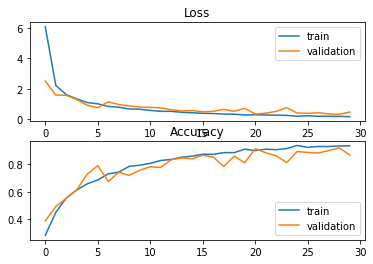

In [16]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

# Test folds performance

In [18]:
import numpy as np

loss = []
accuracy = []

for fold in [5, 7, 8, 9, 10]:
    td = Dataset(dataset_path=f"../data/processed/test_{fold}_07_18_2021.csv", test_size=0)
    x_test, y_test = td.get_splits()
    results = net.model.evaluate(x_test, y_test, batch_size=128)
    loss.append(results[0])
    accuracy.append(results[1])

print("\nAccuracy:")
print(f"\tMean: {np.mean(accuracy)} \n\tStandard deviation: {np.std(accuracy)}")

print("\nLoss:")
print(f"\tMean: {np.mean(loss)} \n\tStandard deviation: {np.std(loss)}")

7/7 [==============================] - 0s 2ms/step - loss: 3.1715 - accuracy: 0.5651

Accuracy:
	Mean: 0.5171466588973999 
	Standard deviation: 0.05021371615777526

Loss:
	Mean: 3.4827600002288817 
	Standard deviation: 0.24574683474913656
